# Data Wrangling for LOB
"LOB" usually refers to "Limit Order Book". In the financial markets, a limit order book is a mechanism for recording and ordering buy and sell orders on an exchange or trading platform. Each order specifies a price and quantity. Buy orders (the price at which to buy) will be listed in descending order, while sell orders (the price at which to sell) will be listed in descending order. This helps the trader to understand the supply and demand situation in the market, as well as the possible direction of price movements.

LOB files are txt files with a specific format. The data is not in a format that is easy to work with. This notebook will read the data from the txt files and convert it into a pandas dataframe. The data will be cleaned and transformed into a format that is easy to work with.

## 1. Read the data
Original lob data is in a txt file, which does not have column names. Now we need to read the data and parse it into a pandas dataframe in a correct format.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
# create a function to parse the LOB entry,which means to extract the timestamp, exchange, and orders
# def parse_lob_entry(entry):
#     timestamp, exchange, orders = entry
#     bids = orders[0][1]
#     asks = orders[1][1]
#     return timestamp, exchange, bids, asks


# read the lob using the parse_lob_entry function and read_lines
def read_lob_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lob_data = []
        for line in lines:
            # replace single quotes with double quotes and ensure that internal double quotes are properly escaped
            fixed_line = line.replace("'", '"').replace('Exch0', '"Exch0"')
            lob_data.append(json.loads(fixed_line))
    return pd.DataFrame(lob_data, columns=["Timestamp", "Exchange", "Orders"])


# read the LOB file AS AN EXAMPLE
file_path = './datasets/UoB_Set01_2025-01-02LOBs.txt'
lob_data = read_lob_file(file_path)

print(lob_data.head())

   Timestamp Exchange                                Orders
0      0.000    Exch0                [[bid, []], [ask, []]]
1      0.279    Exch0          [[bid, [[1, 6]]], [ask, []]]
2      1.333    Exch0  [[bid, [[1, 6]]], [ask, [[800, 1]]]]
3      1.581    Exch0  [[bid, [[1, 6]]], [ask, [[799, 1]]]]
4      1.643    Exch0  [[bid, [[1, 6]]], [ask, [[798, 1]]]]


- Timestamp: the time when the data was recorded
- Exchange: the exchange where the data was recorded
- Orders: the orders in the LOB
    - [bid, [a,b]]: a is the price and b is the volume for the bid
    - [ask, [a,b]]: a is the price and b is the volume for the ask
---

There are much information in the orders column. We need to parse the orders column to extract the bid and ask information.

In [5]:
# create a function to parse the Orders column
# add new columns to the DataFrame for the bid and ask prices and quantities
def expand_orders(df):
    # initialize lists to store the expanded data
    bid_prices, bid_quantities, ask_prices, ask_quantities = [], [], [], []

    # iterate over the DataFrame rows
    for index, row in df.iterrows():
        # set the default values to None, in case the row is empty
        bid_price = bid_quantity = ask_price = ask_quantity = None

        # extract the bid and ask lists from the Orders column
        bids = row['Orders'][0][1] 
        asks = row['Orders'][1][1]  

        if bids:  
            bid_price, bid_quantity = bids[0]  # extract the price and quantity of the first bid

        if asks: 
            ask_price, ask_quantity = asks[0]  # extract the price and quantity of the first ask

        # append the extracted values to the lists
        bid_prices.append(bid_price)
        bid_quantities.append(bid_quantity)
        ask_prices.append(ask_price)
        ask_quantities.append(ask_quantity)

    # add the expanded columns to the DataFrame
    df['Bid Price'] = bid_prices
    df['Bid Quantity'] = bid_quantities
    df['Ask Price'] = ask_prices
    df['Ask Quantity'] = ask_quantities

    return df

lob_expanded = expand_orders(lob_data)
print(lob_expanded.head())

# Save the expanded data to a csv file
# lob_expanded.to_csv('./datasets/lob_data_expanded.csv', index=False)

   Timestamp Exchange                                Orders  Bid Price  \
0      0.000    Exch0                [[bid, []], [ask, []]]        NaN   
1      0.279    Exch0          [[bid, [[1, 6]]], [ask, []]]        1.0   
2      1.333    Exch0  [[bid, [[1, 6]]], [ask, [[800, 1]]]]        1.0   
3      1.581    Exch0  [[bid, [[1, 6]]], [ask, [[799, 1]]]]        1.0   
4      1.643    Exch0  [[bid, [[1, 6]]], [ask, [[798, 1]]]]        1.0   

   Bid Quantity  Ask Price  Ask Quantity  
0           NaN        NaN           NaN  
1           6.0        NaN           NaN  
2           6.0      800.0           1.0  
3           6.0      799.0           1.0  
4           6.0      798.0           1.0  


## 2. Data Cleaning
### 1. Check the missing values

In [12]:
lob_expanded.describe()

,Timestamp,Bid Price,Bid Quantity,Ask Price,Ask Quantity
count,352970.000000,352965.000000,352965.000000,352964.000000,352964.000000
mean,15416.646768,279.900319,4.409508,292.335017,3.002683
std,8783.716539,15.127666,3.913245,32.427342,1.658376
min,0.000000,1.000000,1.000000,243.000000,1.000000
25%,7946.640750,272.000000,2.000000,281.000000,2.000000
50%,15412.983000,284.000000,3.000000,291.000000,3.000000
75%,23044.772250,290.000000,6.000000,297.000000,4.000000
max,30599.945000,303.000000,41.000000,800.000000,16.000000


In [6]:
# check missing values
print(lob_expanded.isnull().sum())

Timestamp       0
Exchange        0
Orders          0
Bid Price       5
Bid Quantity    5
Ask Price       6
Ask Quantity    6
dtype: int64


There are several missing values in the Bid Price, Bid Quantity, Ask Price, and Ask Quantity columns. We can drop the rows with missing values.

In [5]:
# drop the rows with missing values
# lob_expanded=pd.read_csv('./datasets/lob_data_expanded.csv')
lob_expanded_clean = lob_expanded.dropna()
print(lob_expanded_clean.isnull().sum())
# save the cleaned data to a csv file
# lob_expanded_clean.to_csv('./datasets/lob_expanded_clean.csv', index=False)
# print(lob_expanded_clean.describe())

# check the rows compared to the original data
# print(lob_expanded.shape) # [352970, 7]
# print(lob_expanded_clean.shape) # [352960, 7]

Timestamp       0
Exchange        0
Orders          0
Bid Price       0
Bid Quantity    0
Ask Price       0
Ask Quantity    0
dtype: int64
(352970, 7)
(352960, 7)


### 2. Check the outliers


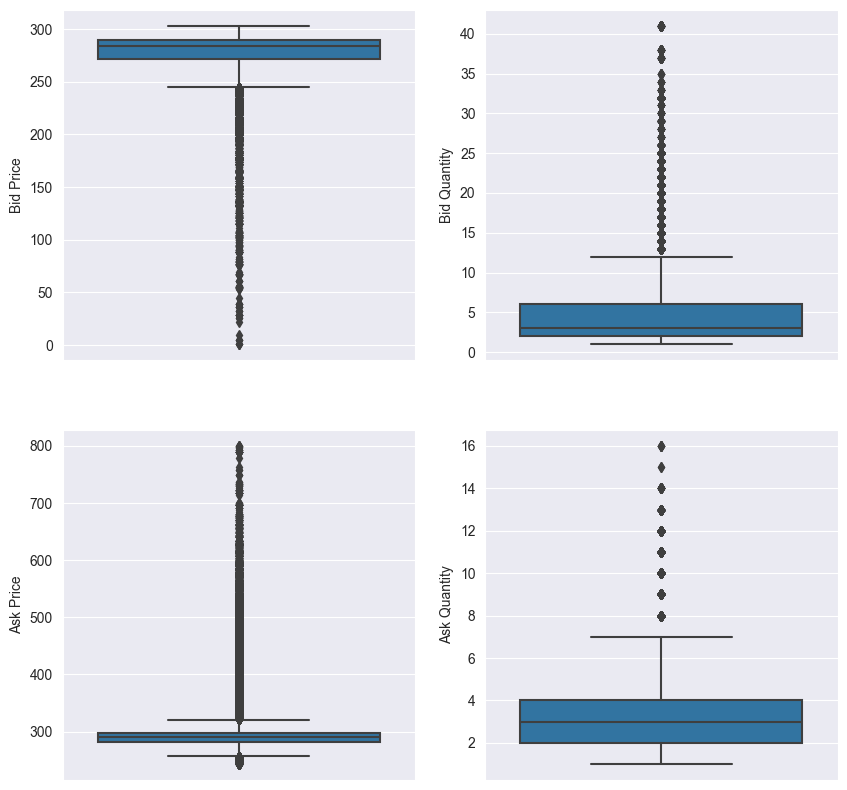

In [21]:
# use sns.boxplot to check the outliers
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.boxplot(y=lob_expanded_clean['Bid Price'], ax=ax[0, 0])
sns.boxplot(y=lob_expanded_clean['Bid Quantity'], ax=ax[0, 1])
sns.boxplot(y=lob_expanded_clean['Ask Price'], ax=ax[1, 0])
sns.boxplot(y=lob_expanded_clean['Ask Quantity'], ax=ax[1, 1])
plt.show()

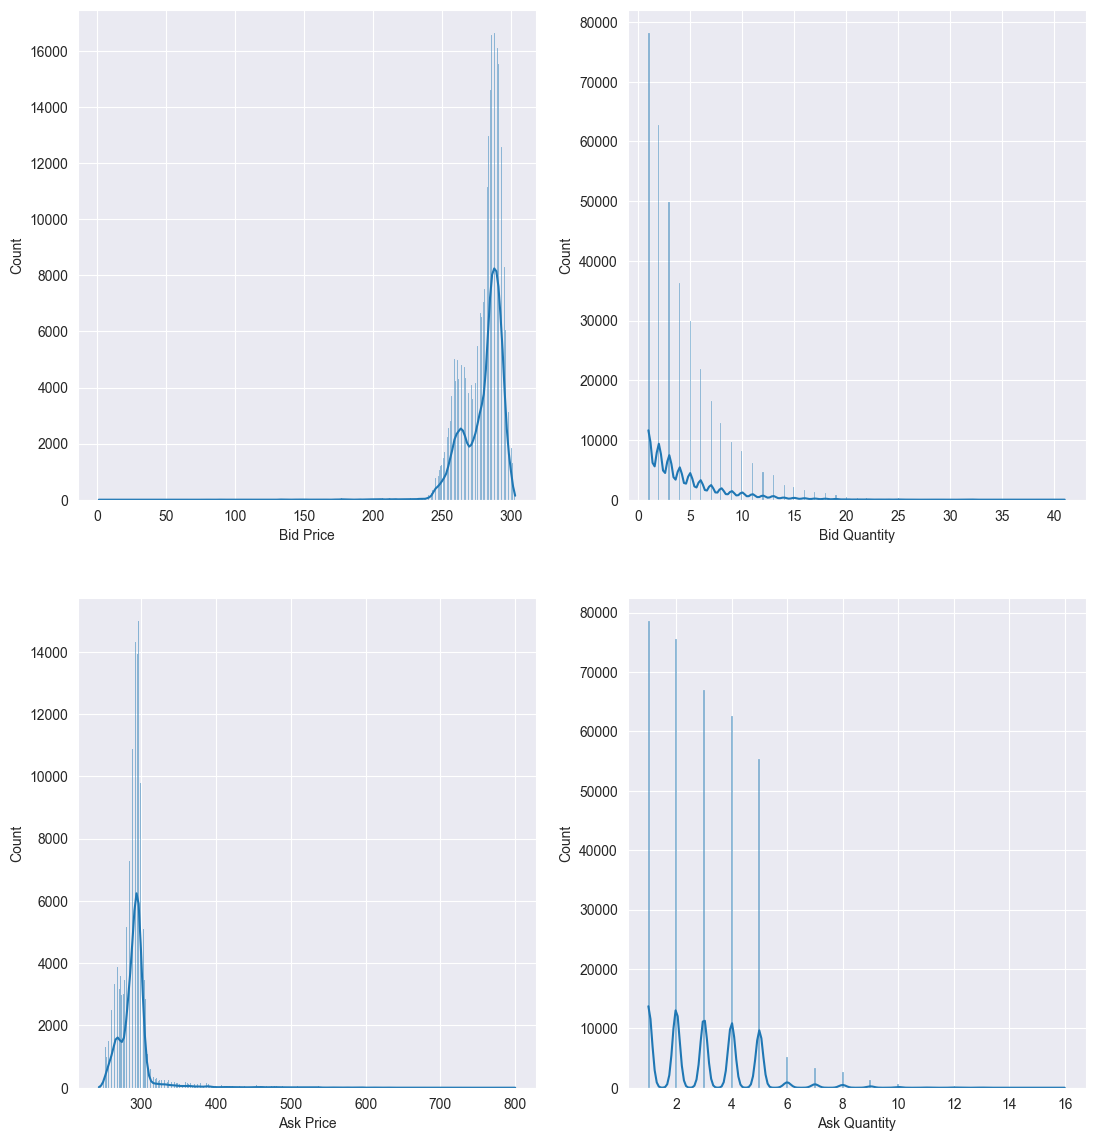

In [23]:
# plot the distribution of the bid and ask prices and quantities
fig, ax = plt.subplots(2, 2, figsize=(13, 14))
sns.histplot(lob_expanded_clean['Bid Price'], kde=True, ax=ax[0, 0])
sns.histplot(lob_expanded_clean['Bid Quantity'], kde=True, ax=ax[0, 1])
sns.histplot(lob_expanded_clean['Ask Price'], kde=True, ax=ax[1, 0])
sns.histplot(lob_expanded_clean['Ask Quantity'], kde=True, ax=ax[1, 1])
plt.show()

Combine the distribution and boxplot, we can see that the distribution of the bid and ask prices and quantities are not normal. As a result, the outliers in the boxplot are not real outliers. We can keep the data as it is.